# 2. Topologycal Analysis

# **INTRO**

# TABLE CONTENTS

In [ ]:
import praw
import pandas as pd
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import networkx as nx

# load
df_general = pd.read_csv('../data/aot_general.csv')
df_ending = pd.read_csv('../data/aot_ending.csv')
df_general['created_utc'] = pd.to_datetime(df_general['created_utc'])
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])

In [2]:
# login with your reddit credentials

def login_reddit(reddit_credentials):
    with open(reddit_credentials, "r") as f:
        credentials = json.load(f)

    reddit = praw.Reddit(
        client_id=credentials['CLIENT_ID'],
        client_secret=credentials['SECRET_TOKEN'],
        password=credentials['PASSWORD'],
        user_agent='Tutorial by /user/SMA202324',
        username=credentials['USERNAME'],
        check_for_async=False
    )

    if reddit.read_only:
        print("Reddit login failed. Please check your credentials.")
        return None
    else:
        print(f"🤖 Reddit login successful. Welcome {reddit.user.me()}")
        return reddit
    
reddit_credentials = "../data/redditCredentials.json"
reddit = login_reddit(reddit_credentials)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


🤖 Reddit login successful. Welcome Disastrous_Walk_7254


In [3]:
df_general.head()

,author,author_flair_text,clicked,comments,created_utc,distinguished,edited,id,is_original_content,is_self,...,poll_data,saved,score,selftext,spoiler,stickied,subreddit,title,upvote_ratio,url
0,FoxicalOW,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-01-14 16:21:28,NaN,False,kx7nlm,True,False,...,NaN,False,29142,NaN,False,False,attackontitan,I built Shiganshina in Minecraft 1:1,0.99,https://i.redd.it/zlx4dtb7fbb61.jpg
1,kinekocat,Potato Girl Enjoyer :sasha_potato:,False,<praw.models.comment_forest.CommentForest obje...,2025-02-17 20:25:34,NaN,False,1irsbx6,False,False,...,NaN,False,26708,NaN,False,False,attackontitan,How do I even react to this??,0.98,https://i.redd.it/c7jyj8d23rje1.jpeg
2,ProfessorRigby,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-01-25 07:36:27,NaN,False,l4hxj7,False,False,...,NaN,False,24543,NaN,False,False,attackontitan,"Dad: ""Stop watching those stupid cartoons!"" Tw...",0.99,https://v.redd.it/7ewif8yjbfd61
3,NaN,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-10-05 22:44:40,NaN,False,q2569s,False,False,...,NaN,False,23331,NaN,False,False,attackontitan,well?,0.97,https://i.redd.it/ai437vhk1pr71.jpg
4,Psplus01,NaN,False,<praw.models.comment_forest.CommentForest obje...,2021-02-01 11:14:59,NaN,False,la0032,False,False,...,NaN,False,22645,NaN,False,False,attackontitan,Eren vs Annie in a nutshell,0.98,https://i.redd.it/oulo1tczcue61.jpg


We have seen that the graph gets huge very rapidly... We take a subset of the submissions. The top k% of submssions from each of the subreddit that we have seen, ordered by score.

In [4]:
# Define the percentage for top posts
k_percent = 30  # You can adjust this value

def get_top_k_percent_by_subreddit(df, k_percent):
    """Get top k% posts from each subreddit separately"""
    subreddits = df['subreddit'].unique()
    df_top = pd.DataFrame()
    
    for subreddit in subreddits:
        subreddit_posts = df[df['subreddit'] == subreddit]
        top_k_count = int(len(subreddit_posts) * k_percent / 100)
        if top_k_count > 0:  # Only process if there are posts to select
            top_posts = subreddit_posts.nlargest(top_k_count, 'score')
            df_top = pd.concat([df_top, top_posts], ignore_index=True)
    
    return df_top

# Get top k% posts for each subreddit
df_general_top = get_top_k_percent_by_subreddit(df_general, k_percent)
df_ending_top = get_top_k_percent_by_subreddit(df_ending, k_percent)

# Print summary
print(f"Top {k_percent}% posts from general subreddits ({len(df_general_top)} total posts):")
for subreddit in df_general['subreddit'].unique():
    count = len(df_general_top[df_general_top['subreddit'] == subreddit])
    print(f"  {subreddit}: {count} posts")

print(f"\nTop {k_percent}% posts from ending subreddits ({len(df_ending_top)} total posts):")
for subreddit in df_ending['subreddit'].unique():
    count = len(df_ending_top[df_ending_top['subreddit'] == subreddit])
    print(f"  {subreddit}: {count} posts")

Top 30% posts from general subreddits (90 total posts):
  attackontitan: 30 posts
  titanfolk: 30 posts
  AttackOnRetards: 30 posts

Top 30% posts from ending subreddits (90 total posts):
  attackontitan: 30 posts
  titanfolk: 30 posts
  AttackOnRetards: 30 posts


Get the comments from our submssions, we gather until the third level (replies of the replies of the replies).

In [5]:
def get_comments(df):
    # get comments till the third level

    res = []
    for index, i in df.iterrows():
        # Find author and comments
        sub_auth= i['author']
        sub= reddit.submission(i['id'])
        sub.comments.replace_more(limit=20)
        # Extract author for each comment
        for top_level_comment in sub.comments:
            # author of the top level comment
            top_l_auth = top_level_comment.author
            res.append({
                'parent': str(sub_auth), 
                'child': str(top_l_auth), 
                'text_comment': top_level_comment.body
            })
            # replies - second level comments
            for second_level_comment in top_level_comment.replies:
                # again we get the authors of the replies and create the pairs we are interested in 
                sec_l_auth = second_level_comment.author
                res.append({
                    'parent': str(top_l_auth), 
                    'child': str(sec_l_auth), 
                    'text_comment': second_level_comment.body
                })
                # replies of the repleis - third level comments
                for third_level_comment in second_level_comment.replies:
                    res.append({
                        'parent': str(sec_l_auth), 
                        'child': str(third_level_comment.author), 
                        'text_comment': third_level_comment.body
                    })
    return pd.DataFrame(res)

In [ ]:
comments_df_general = get_comments(df_general_top)
comments_df_general.to_csv('../data/comments_graph_general_top30percent.csv', index=False)
comments_df_ending = get_comments(df_ending_top)
comments_df_ending.to_csv('../data/comments_graph_ending_top30percent.csv', index=False)
print("length of comments df general: ", len(comments_df_general))
print("length of comments df ending: ", len(comments_df_ending))

length of comments df general:  14816
length of comments df ending:  20669


In [20]:
comments_df_ending.head()

,parent,child,text_comment
0,joaopaulofoo,Umer123321,Armin Mikasa and Eren have finally seen the Sea.
1,Umer123321,None,"It was kinda bittersweet for Eren, but I liked..."
2,None,s4l4o6t3h,It being bittersweet for Eren was honestly my ...
3,None,Umer123321,We wait for a year for the ending to all of this
4,Umer123321,ashai1994,How? where


In [ ]:
# load
# comments_df_general = pd.read_csv('../data/comments_graph_general_top30percent.csv')
comments_df_ending = pd.read_csv('../data/comments_graph_ending_top30percent.csv')

In [ ]:
# Count occurrences of 'None' strings in comments_df_ending
none_count_ending = (comments_df_ending == 'None').sum().sum()

print(f"Total 'None' string occurrences in comments_df_ending: {none_count_ending}")

# Count 'None' strings by column
print("\n'None' string occurrences by column in comments_df_ending:")
print((comments_df_ending == 'None').sum())

Total 'None' string occurrences in comments_df_ending: 5085

'None' string occurrences by column in comments_df_ending:
parent          1679
child           3406
text_comment       0
dtype: int64


In [73]:
def clean_comments_dataframe(df):
    """Remove rows with 'None' strings, 'nan' strings, or actual NaN values from comments dataframe"""
    df_clean = df[
        (df['parent'] != 'None') & 
        (df['child'] != 'None') &
        (df['parent'] != 'nan') & 
        (df['child'] != 'nan') &
        (~pd.isna(df['parent'])) & 
        (~pd.isna(df['child']))
    ]
    
    print(f"Original dataframe shape: {df.shape}")
    print(f"Cleaned dataframe shape: {df_clean.shape}")
    print(f"Removed {len(df) - len(df_clean)} rows")
    
    return df_clean

comments_df = clean_comments_dataframe(comments_df_ending)
comments_df.shape
# this is going to be our final comments dataframe
comments_df.to_csv('../data/comments_graph_general_top30percent_clean.csv', index=False)

Original dataframe shape: (20669, 3)
Cleaned dataframe shape: (15912, 3)
Removed 4757 rows


## Build the Graph

We have chosen to build a Graph of Replies 

$G = (N, E)$, $N = \{\text{users}\} = \{u_1, u_2, \cdots, u_n\}$, $N = \{\text{comments}\} = \{(u_i, u_j)\} \,\,\forall \,\, i,j \,\text{ s. t. }\,  u_j \text{ replied to } u_i $

In [ ]:
# Create a graph from the cleaned comments dataframe
G = nx.Graph()
for index, r in comments_df.iterrows():
    G.add_edge(r['parent'], r['child'])

print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the graph: 8903 nodes and 12366 edges


In [ ]:
# remove self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))
print(f"Size of the graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the graph: 8903 nodes and 12326 edges


In [ ]:
# we take into consideration only the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
print(f"Size of the largest connected component: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Size of the largest connected component: 8862 nodes and 12302 edges


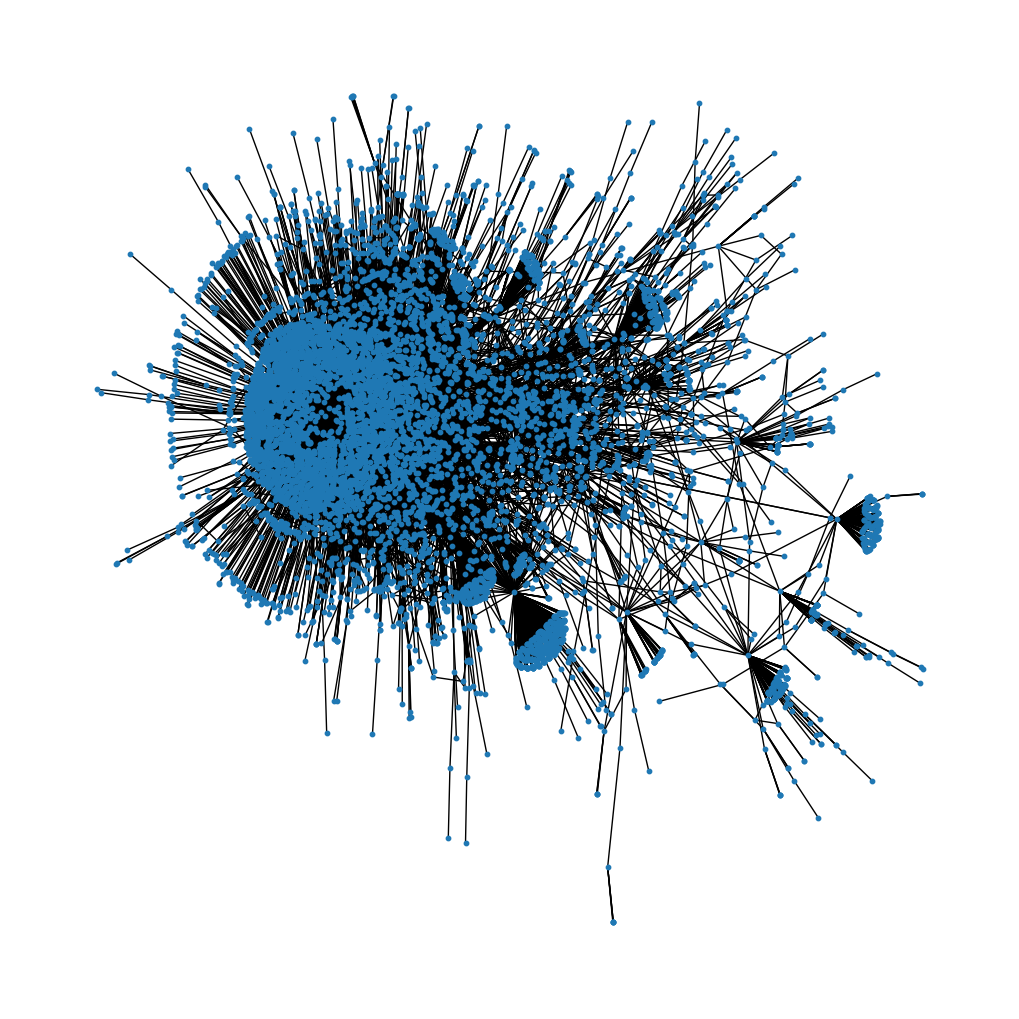

In [12]:
plt.figure(figsize=(10,10))
nx.draw_spring(G, node_size=10, with_labels=False)
plt.show()

In [39]:
# some graph statistics
print("Radius:", nx.radius(G))
print("Diameter:", nx.diameter(G))
print("Average shortest path length:", round(nx.average_shortest_path_length(G), 5))
print("Average clustering coefficient:", round(nx.average_clustering(G), 5))
print("Density:", round(nx.density(G), 5))

Radius: 6
Diameter: 11
Average shortest path length: 3.57847
Average clustering coefficient: 0.10621
Density: 0.00031


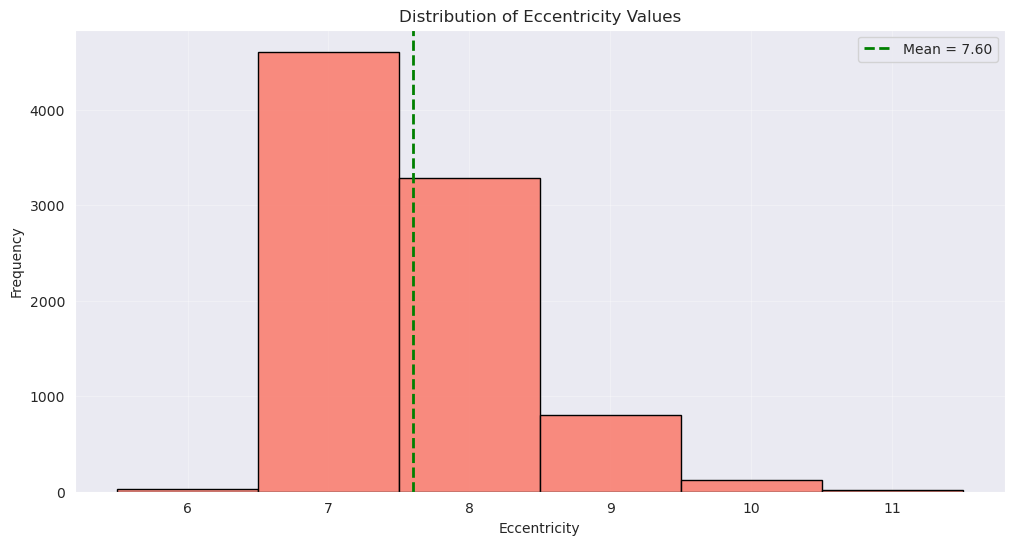

In [50]:
# eccentricity of the nodes
ecc = nx.eccentricity(G)

plt.figure(figsize=(12, 6))
# hitogram of the eccentricity values of our nodes
# center bins on integers
ecc_values = list(ecc.values())
min_ecc = min(ecc_values)
max_ecc = max(ecc_values)
bins = np.arange(min_ecc - 0.5, max_ecc + 1.5, 1)

sns.histplot(ecc_values, bins=bins, alpha=0.9, color='salmon', edgecolor='black')
plt.axvline(np.mean(ecc_values), color='green', linestyle='--', linewidth=2, label=f'Mean = {np.mean(ecc_values):.2f}')
plt.title('Distribution of Eccentricity Values')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')
plt.xticks(range(min_ecc, max_ecc + 1))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# assortativity
r = nx.degree_assortativity_coefficient(G)
print(f"degree assortativity coefficient: {r:.4f}")

degree assortativity coefficient: -0.2326


With social network we should see a positive assortativity value. But at the end our graph doesn't really show the behaviour of a complex network, since we have just this single huge cluster in the middle.

## Centrality measures

### 1. Degree Centrality

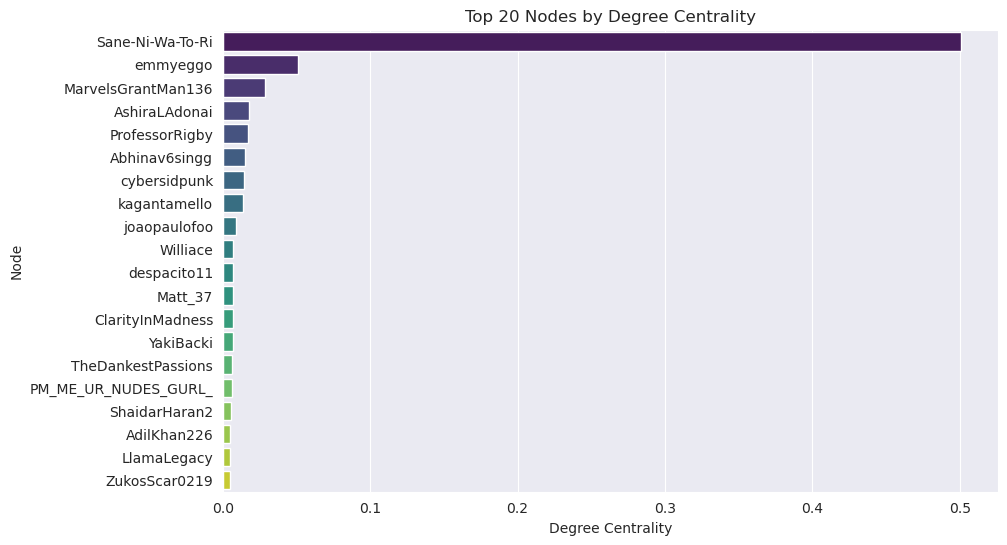

In [62]:
dg_cen = nx.degree_centrality(G)
dg_cen_df= pd.DataFrame(dg_cen.items(), columns=['node','dg_c'])
dg_cen_df = dg_cen_df.sort_values(by='dg_c', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='dg_c', y='node', data=dg_cen_df.head(20), palette='viridis', hue='node', legend=False)
plt.title("Top 20 Nodes by Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Node")
plt.show()

Mr. Sane-Ni-Wa-To-Ri is playing a big role in our aot discussions...

In [61]:
# position of the nodes in the graph
# computed once and then reused for plotting
pos = nx.spring_layout(G, iterations=50)

We encode the degree centrality as the node size

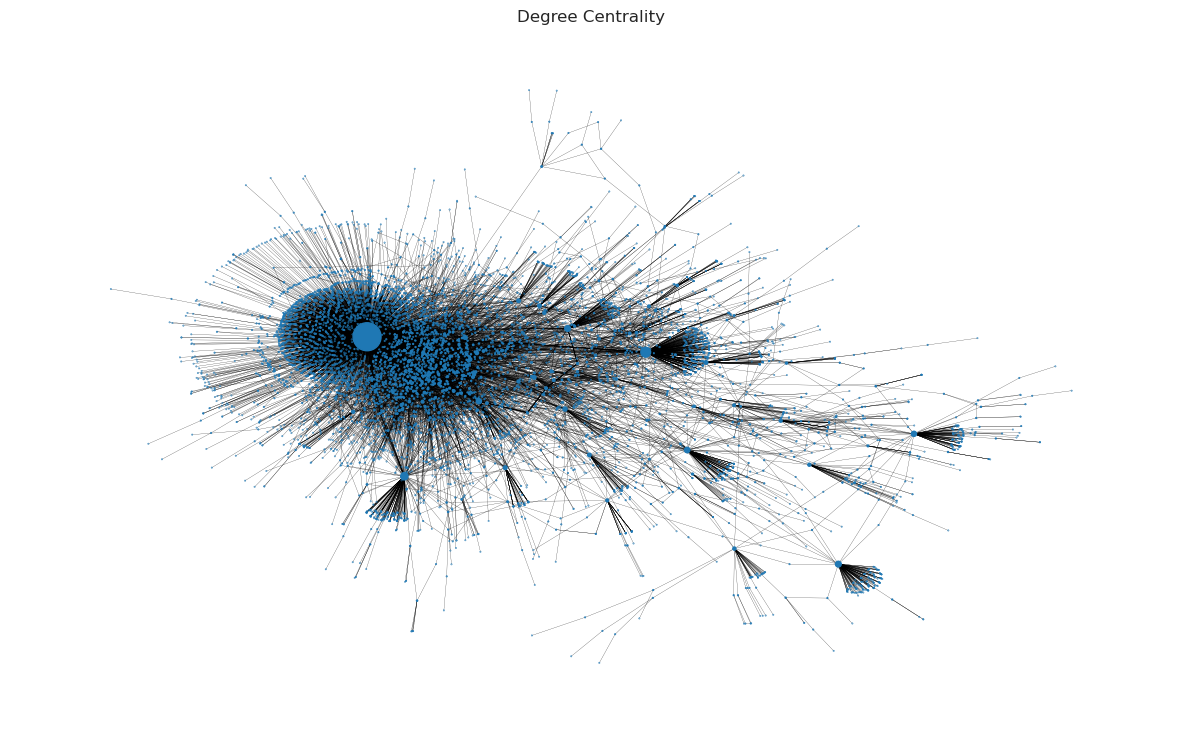

In [ ]:
node_size = [np.log(v + 1) * 1000 for v in dg_cen.values()]
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=node_size, with_labels= False, width= 0.15)
ax.set_title("Degree Centrality")
plt.show()

### 2. Betweenness Centrality

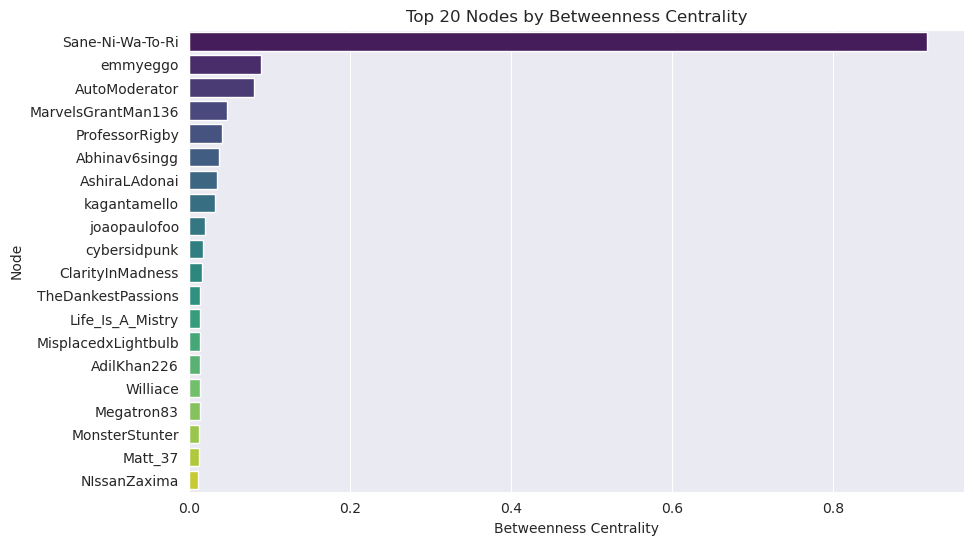

In [ ]:
bt_cen = nx.betweenness_centrality(G)
bt_cen_df= pd.DataFrame(bt_cen.items(), columns=['node','bt_c'])
bt_cen_df = bt_cen_df.sort_values(by='bt_c', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='bt_c', y='node', data=bt_cen_df.head(20), palette='viridis', hue='node', legend=False)
plt.title("Top 20 Nodes by Betweenness Centrality")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Node")
plt.show()

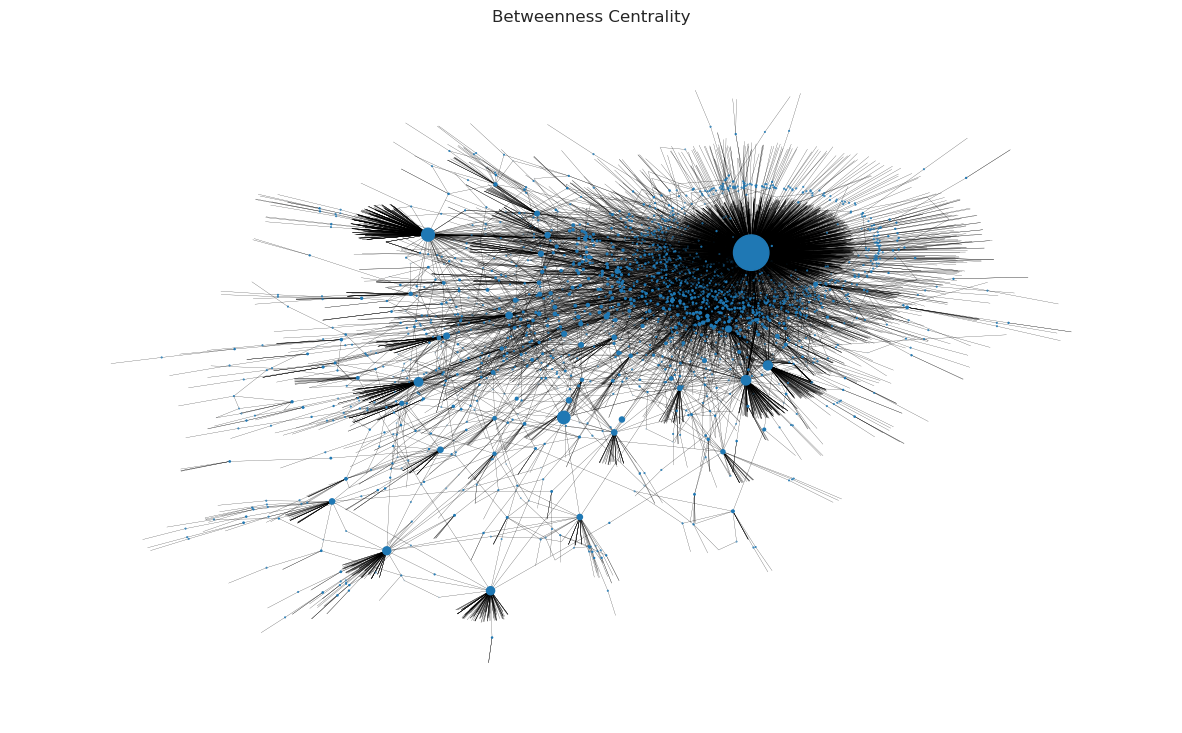

In [70]:
node_size = [np.log(v + 1) * 1000 for v in bt_cen.values()]
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=node_size, with_labels= False, width= 0.15)
ax.set_title("Betweenness Centrality")
plt.show()

### 3. Closeness Centrality

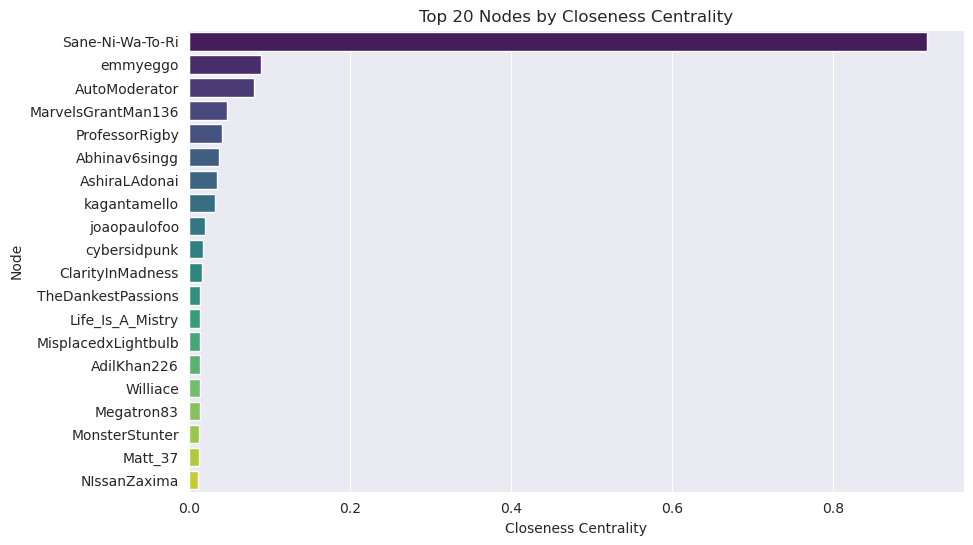

In [68]:
cl_cen = nx.closeness_centrality(G)
cl_cen_df= pd.DataFrame(bt_cen.items(), columns=['node','cl_c'])
cl_cen_df = cl_cen_df.sort_values(by='cl_c', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='cl_c', y='node', data=cl_cen_df.head(20), palette='viridis', hue='node', legend=False)
plt.title("Top 20 Nodes by Closeness Centrality")
plt.xlabel("Closeness Centrality")
plt.ylabel("Node")
plt.show()

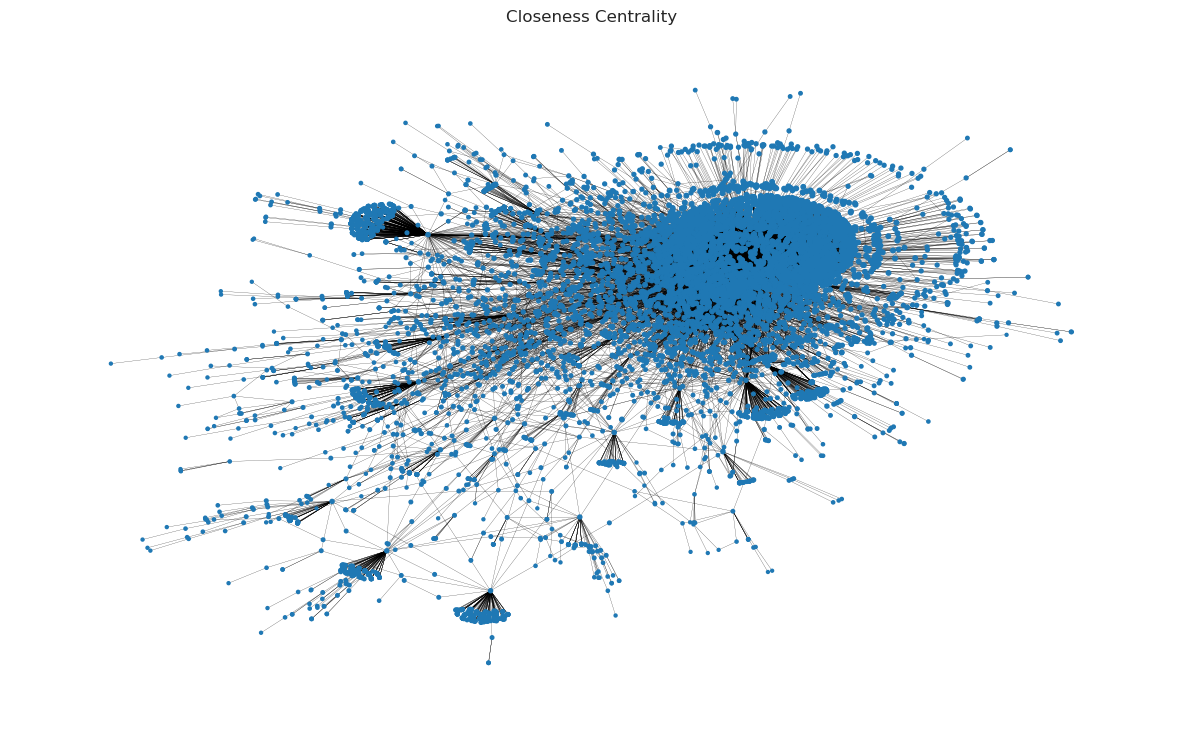

In [69]:
node_size = [v * 30 for v in cl_cen.values()]
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=node_size, with_labels=False, width=0.15)
ax.set_title("Closeness Centrality")
plt.show()

In [ ]:
# save graph object to file
pickle.dump(G, open('../data/comments_graph.pickle', 'wb'))